In [124]:
## 98273 Data Mining Coursework
## We are going to apply Data Mining algorithms to
## the above dataset to investigate insights regarding to it

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import mlxtend as mlx
import altair as alt
from sklearn.cluster import KMeans
import sys
import datetime 
from math import isnan

In [2]:
data = pd.read_csv('OnlineRetail.csv')
data['Description'] = data['Description'].str.strip()

#data.dropna(axis=0, subset=['InvoiceNo'], inplace=True)

data = data.dropna(axis =0)
data['InvoiceNo'] = data['InvoiceNo'].astype('str')

#data = data[~data['InvoiceNo'].str.contains('C')]

# We are making the description to lower case for massive managing
data['Description'] = data['Description'].str.lower()
# we are going to convert column names to lower as well
data.columns = data.columns.str.lower()
data['description'] = data['description'].astype('str')
data = data[~data['description'].str.contains('wrongly')]
data['customerid'] = data['customerid'].astype('int')

In [4]:
data.head(10)

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country
0,536365,85123A,white hanging heart t-light holder,6,01/12/2010 08:26,2.55,17850,United Kingdom
1,536365,71053,white metal lantern,6,01/12/2010 08:26,3.39,17850,United Kingdom
2,536365,84406B,cream cupid hearts coat hanger,8,01/12/2010 08:26,2.75,17850,United Kingdom
3,536365,84029G,knitted union flag hot water bottle,6,01/12/2010 08:26,3.39,17850,United Kingdom
4,536365,84029E,red woolly hottie white heart.,6,01/12/2010 08:26,3.39,17850,United Kingdom
5,536365,22752,set 7 babushka nesting boxes,2,01/12/2010 08:26,7.65,17850,United Kingdom
6,536365,21730,glass star frosted t-light holder,6,01/12/2010 08:26,4.25,17850,United Kingdom
7,536366,22633,hand warmer union jack,6,01/12/2010 08:28,1.85,17850,United Kingdom
8,536366,22632,hand warmer red polka dot,6,01/12/2010 08:28,1.85,17850,United Kingdom
9,536367,84879,assorted colour bird ornament,32,01/12/2010 08:34,1.69,13047,United Kingdom


In [24]:
def encode(x):
    if (x <= 0):
        return 0
    elif (x >= 1):
        return 1


In [25]:
basket = (data.groupby(['customerid', 'description'])['quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('customerid'))

In [14]:
basket = (data[data['country'] =="United Kingdom"]
          .groupby(['invoiceno', 'description'])['quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('invoiceno'))


In [28]:
basket = (data.groupby(['invoiceno', 'description'])['quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('invoiceno'))


In [29]:
basket_sets = basket.applymap(encode)

In [40]:
frequent_itemsets = apriori(basket_sets, min_support=0.01, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=3)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(60 teatime fairy cake cases),(72 sweetheart fairy cake cases),0.029608,0.022578,0.010005,0.337900,14.966050,0.009336,1.476245
1,(72 sweetheart fairy cake cases),(60 teatime fairy cake cases),0.022578,0.029608,0.010005,0.443114,14.966050,0.009336,1.742532
2,(60 teatime fairy cake cases),(pack of 60 dinosaur cake cases),0.029608,0.023840,0.010050,0.339422,14.237742,0.009344,1.477736
3,(pack of 60 dinosaur cake cases),(60 teatime fairy cake cases),0.023840,0.029608,0.010050,0.421550,14.237742,0.009344,1.677573
4,(60 teatime fairy cake cases),(pack of 60 pink paisley cake cases),0.029608,0.030149,0.012618,0.426180,14.135912,0.011726,1.690165


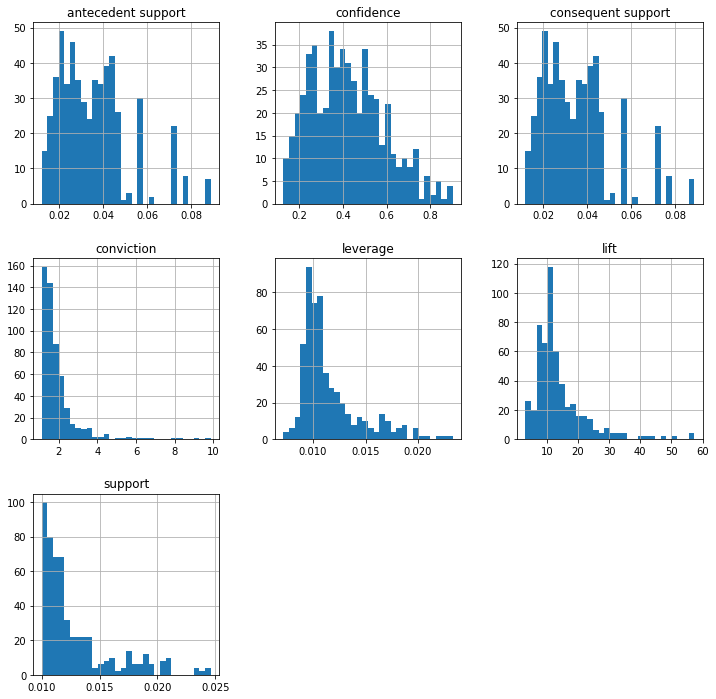

In [42]:
rules.hist(figsize=[12,12], bins = 30)
plt.show()

### Identifying the outliers

Hence the dataset is really huge and we have to scan the data to find potential weaknesses while we eliminating the most noise we can. Thus, we are going to do different plots to see if there are outliers than need to be removed from the dataset

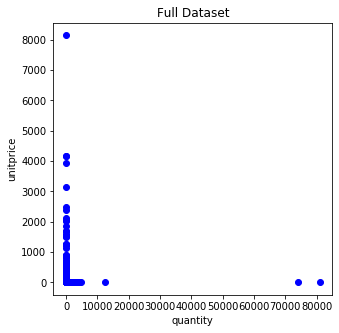

In [116]:
plt.figure(figsize=[5,5])
plt.scatter(data['quantity'], data['unitprice'], c= 'blue')
plt.title('Full Dataset')
plt.xlabel('quantity');plt.ylabel('unitprice')
plt.show()

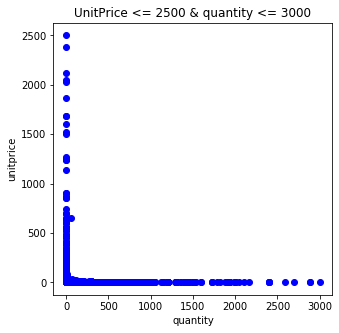

In [123]:
plt.figure(figsize=[5,5])
plt.scatter(data['quantity'], data['unitprice'], c= 'blue')
plt.title('UnitPrice <= 2500 & quantity <= 3000')
plt.xlabel('quantity');plt.ylabel('unitprice')
plt.xlim(-1,3000);plt.ylim(0,2500)
plt.show()

In [122]:
# Thus, the separation is going to be as:

# quantity <= 3000
# unit price <= 2500

data = data[data['quantity'] <= 3000]
data = data[data['unitprice'] <= 2500]

#### Separating the datasets


At this stage we are going to separate our datasets into 2 different datasets;
the buyouts which relies on credit which contain 'C' in the their Invoice Number 
and those without any creidit without the 'C' in the invoice

Moreover, we are going to remove any buyouts which have negative quantity.
We could assume that negative quanity means '<i>return</i>' but we will not deal with that set at the moment

In [134]:
data = data[~data['quantity'] <0]
data['paid_money'] = data['quantity']*data['unitprice']
non_credit = data[~data['invoiceno'].str.contains('C')]
credit = data[data['invoiceno'].str.contains('C')]

In [160]:
non_credit['invoiceno'] = non_credit['invoiceno'].astype('int')
cluster_non_credit = non_credit[['unitprice','quantity','paid_money']]
kmeans = KMeans(n_clusters= 3, random_state=  12).fit(cluster_non_credit)
labels = kmeans.predict(cluster_non_credit)

(0, 5000)

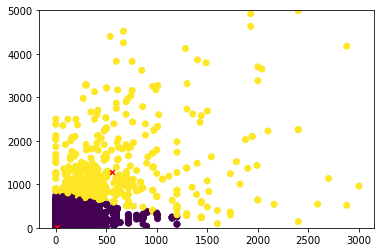

In [168]:
plt.scatter(data['quantity'], data['paid_money'], c =labels)
plt.scatter(kmeans.cluster_centers_[0][1], kmeans.cluster_centers_[0][2], marker='x',c = 'red', s = 22)
plt.scatter(kmeans.cluster_centers_[1][1], kmeans.cluster_centers_[1][2], marker='x',c = 'red',s = 22)
plt.scatter(kmeans.cluster_centers_[2][1], kmeans.cluster_centers_[2][2], marker='x',c = 'red', s = 22)
plt.ylim(0,5000)